This notebook implements policy gradient RL.

### Import libraries

In [86]:
import collections
import dataclasses
import random
from typing import Optional

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as t
from days.atari_wrappers import AtariWrapper
from einops import rearrange, reduce, repeat
from IPython.display import Video
from torch import nn, optim
from tqdm.auto import tqdm
import copy

import rl_tests
from video_recorder import VideoRecorder

### Define networks

In [87]:
class PolicyMLP(nn.Module):
    def __init__(
        self,
        in_size: int,
        hidden_size: int,
        out_size: int,
    ):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.LogSoftmax(dim=-1),
        )

    def forward(
        self,
        obs: t.Tensor,  # Tensor[..., obs_shape]
    ) -> t.Tensor:
        """
        return: Tensor[..., num_actions]
        """
        return self.seq(obs)

    @property
    def device(self):
        return next(self.parameters()).device

    @property
    def dtype(self):
        return next(self.parameters()).dtype

In [88]:
class AtariConv(nn.Module):
    def __init__(self, obs_n_channels, n_action_space):
        super().__init__()
        self.obs_n_channels = obs_n_channels
        self.n_action_space = n_action_space
        self.layers = nn.Sequential(
            nn.Conv2d(obs_n_channels, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, n_action_space),
            # linear / logsoftmax?
        )

    def forward(self, obs):
        if len(obs.shape) == 3:
            obs = rearrange(obs, "h w c -> 1 c h w")
            return self.layers(obs)[0]

        assert len(obs.shape) == 4
        obs = rearrange(obs, "b h w c -> b c h w")
        return self.layers(obs)

    @property
    def device(self):
        return next(self.parameters()).device

    @property
    def dtype(self):
        return next(self.parameters()).dtype

### Policy gradient training

In [119]:
def evaluate(
    model: nn.Module,
    env: gym.Env,
    video_path: Optional[str] = None,
) -> tuple[float, int]:
    total_reward: float = 0
    steps_taken: int = 0

    if video_path is not None:
        recorder = VideoRecorder(env, video_path)

    running_gamma: float = 1
    done: bool = False
    obs: np.ndarray = env.reset()
    while not done:
        if video_path is not None:
            recorder.capture_frame()
        with t.no_grad():
            probs = t.exp(model(t.tensor(obs, dtype=model.dtype, device=model.device)))
        action = t.multinomial(probs, num_samples=1).item()
        obs, reward, done, _ = env.step(action)

        total_reward += reward
        steps_taken += 1

    if video_path is not None:
        recorder.close()
    return total_reward, steps_taken


def policy_grad_train(
    model: nn.Module,
    env: gym.Env,
    n_updates: int,
    batch_size: int,
    eval_freq: int = 100,
    gamma: float = 1.0,
    lr: float = 1e-3,
    seed: int = 42,
):
    env.seed(seed)
    env.action_space.seed(seed)

    opt = optim.Adam(model.parameters(), lr=lr)

    perf_history: list[float] = []
    loss_history: list[float] = []
    obs: np.ndarray = env.reset()

    for i in tqdm(range(n_updates)):

        obs = env.reset()
        trajectories_completed = 0
        done = False

        loss = 0
        steps_taken = 0

        pbar = tqdm(total=batch_size, leave=False)
        while steps_taken < batch_size:
            total_reward: int = 0
            sum_log_probs = 0

            obs = env.reset()
            running_gamma = 1
            done = False
            while not done:
                log_probs = model(t.tensor(obs, dtype=model.dtype, device=model.device))
                action = t.multinomial(t.exp(log_probs.detach()), num_samples=1).item()
                obs, reward, done, _ = env.step(action)

                sum_log_probs += log_probs[action]
                total_reward += reward * running_gamma
                running_gamma *= gamma

                steps_taken += 1
                pbar.update(1)
            trajectories_completed += 1
            loss -= total_reward * sum_log_probs

        pbar.close()

        loss /= trajectories_completed
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        loss_history.append(loss.item())

        if i % eval_freq == 0:
            fresh_env = copy.deepcopy(env)
            fresh_env.seed(seed)
            fresh_env.action_space.seed(seed)

            reward, steps = evaluate(
                model,
                fresh_env,
                f"videos/cartpole_pg/{i:03}.mp4"
            )
            perf_history.append(reward)
    return loss_history, perf_history

In [120]:
SEED = 42
t.manual_seed(SEED)
random.seed(SEED)

env = gym.make("CartPole-v1")
model = PolicyMLP(
    in_size=env.observation_space.shape[0],
    hidden_size=64,
    out_size=env.action_space.n,
).cuda()



In [121]:
evaluate(model, env)

(11.0, 11)

In [122]:
loss_history, perf_history = policy_grad_train(
    model = model,
    env = env,
    n_updates = 40,
    batch_size = 5000,
    eval_freq = 1,
    gamma = 1.0,
    lr = 1e-2,
    seed = 42,
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

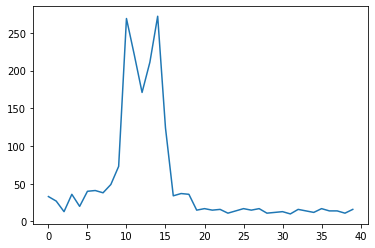

In [123]:
plt.plot(perf_history)

### Rewards to go

In [129]:
def policy_grad_train_rtg(
    model: nn.Module,
    env: gym.Env,
    n_updates: int,
    batch_size: int,
    eval_freq: int = 100,
    gamma: float = 1.0,
    lr: float = 1e-3,
    seed: int = 42,
):
    env.seed(seed)
    env.action_space.seed(seed)

    opt = optim.Adam(model.parameters(), lr=lr)

    perf_history: list[float] = []
    loss_history: list[float] = []
    obs: np.ndarray = env.reset()

    for i in tqdm(range(n_updates)):

        obs = env.reset()
        trajectories_completed = 0
        done = False

        loss = 0
        steps_taken = 0

        pbar = tqdm(total=batch_size, leave=False)
        while steps_taken < batch_size:
            stored_log_probs = []
            rewards = []

            obs = env.reset()
            running_gamma = 1
            done = False
            while not done:
                log_probs = model(t.tensor(obs, dtype=model.dtype, device=model.device))
                action = t.multinomial(t.exp(log_probs.detach()), num_samples=1).item()
                obs, reward, done, _ = env.step(action)

                stored_log_probs.append(log_probs[action])
                rewards.append(reward * running_gamma)
                running_gamma *= gamma

                steps_taken += 1
                pbar.update(1)
            trajectories_completed += 1
            for j in range(len(stored_log_probs)):
                loss -= sum(rewards[j:]) * stored_log_probs[j]

        pbar.close()

        opt.zero_grad()
        loss /= trajectories_completed
        loss_history.append(loss.item())
        loss.backward()
        opt.step()

        if i % eval_freq == 0:
            fresh_env = copy.deepcopy(env)
            fresh_env.seed(seed)
            fresh_env.action_space.seed(seed)

            reward, steps = evaluate(
                model,
                fresh_env,
                f"videos/cartpole_pg_tg/{i:03}.mp4"
            )
            perf_history.append(reward)
    return loss_history, perf_history

In [130]:
SEED = 42
t.manual_seed(SEED)
random.seed(SEED)

env = gym.make("CartPole-v1")
model = PolicyMLP(
    in_size=env.observation_space.shape[0],
    hidden_size=64,
    out_size=env.action_space.n,
).cuda()

evaluate(model, env)

loss_history_rtg, perf_history_rtg = policy_grad_train_rtg(
    model = model,
    env = env,
    n_updates = 40,
    batch_size = 5000,
    eval_freq = 1,
    gamma = 1.0,
    lr = 1e-2,
    seed = 42,
)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

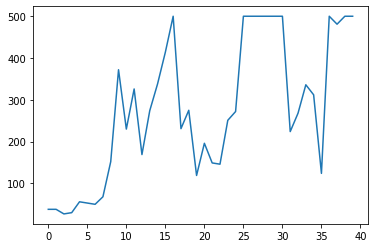

In [131]:
plt.plot(perf_history_rtg)

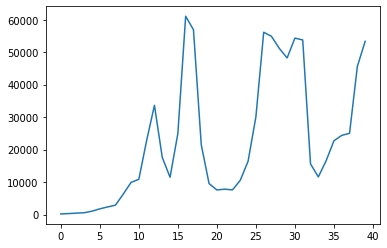

In [132]:
plt.plot(loss_history_rtg)